In [1]:
#Including all the necessary libraries
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import os
import copy

import torch
from torch.utils.data import DataLoader
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
import cv2

/storage/home/hpaceice1/vkondepudi3/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LABELS_Severity = {35: 0, 43: 0, 47: 1, 53: 1, 61: 2, 65: 2, 71: 2, 85: 2}
mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor(),normalize,])

In [3]:
class OCTDataset(Dataset):
    def __init__(self, args, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv(args.annot_train_prime)
        elif subset == 'test':
            self.annot = pd.read_csv(args.annot_test_prime)
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser(args.data_root)
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self._labels)         

In [4]:
class NotebookArgs:
    def __init__(self, annot_train_prime = 'df_prime_train.csv', annot_test_prime = 'df_prime_test.csv', data_root = '/storage/home/hpaceice1/shared-classes/materials/ece8803fml/'):
        self.annot_train_prime = annot_train_prime
        self.annot_test_prime = annot_test_prime
        self.data_root = data_root
args = NotebookArgs()

In [5]:
#loading the dataset
trainset = OCTDataset(args, 'train', transform=transform)
testset = OCTDataset(args, 'test', transform=transform)

# Define hyperparameters
batch_size = 32
num_epochs = 1

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [6]:
def get_X_y_from_loader(loader):
    X, y = [], []
    for sample in tqdm(loader, total=len(loader)):
        images, labels = sample[0], sample[1]
        X.extend([a.numpy().flatten() for a in images])
        y.extend([a.numpy().flatten() for a in labels])
        break
    return X,y

In [7]:
X_train, y_train = get_X_y_from_loader(train_loader)

  0%|          | 0/758 [00:00<?, ?it/s]


In [8]:
image = X_train[15].reshape((224,224))
label = y_train[15]
print(image.dtype)

float32


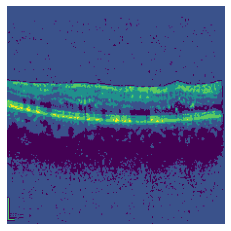

In [9]:
import matplotlib.pyplot as plt

img_uint8 = cv2.convertScaleAbs(image)
# Plot the image using matplotlib
plt.imshow(img_uint8)
plt.axis('off')
plt.show()

In [10]:
sift = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.001, edgeThreshold=5)
# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(img_uint8, None)
descriptors.shape
print(descriptors.flatten().shape)

(6400,)


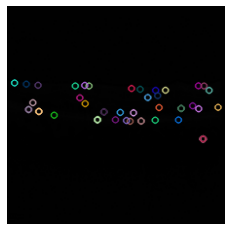

In [11]:
# Draw keypoints on the image
img_keypoints = cv2.drawKeypoints(img_uint8, keypoints, None)
plt.imshow(img_keypoints)
plt.axis('off')
plt.show()

In [12]:
def get_X_y_from_loader(loader):
    X, y = [], []
    i=0
    for sample in tqdm(loader, total=len(loader)):
        i = i+1
        images, labels = sample[0], sample[1]
        X.extend([a.numpy()[0] for a in images])
        y.extend([a.numpy().flatten() for a in labels])
        #break
        #if(i == 1000):
           #break
    return X,y
X_train, y_train = get_X_y_from_loader(train_loader)
print(len(X_train))

100%|██████████| 758/758 [01:19<00:00,  9.49it/s]

24252


In [13]:
#performing sift on train set
X_train_sift = []
i=0
for i in tqdm(range(len(X_train))):   
    #X_hog = X_train[i].reshape((224,224))
    img_uint8 = cv2.convertScaleAbs(X_train[i])
    sift = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.001, edgeThreshold=5)
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img_uint8, None)
    descriptors=descriptors.flatten()
    descriptors= descriptors[:6400] 
    X_train_sift.append(descriptors)
    i =i+1
    if i==10000:
        break
print(X_train_sift[0].shape)
print(len(X_train_sift))

 41%|████      | 9999/24252 [01:19<01:53, 125.72it/s]

(6400,)
10000


In [14]:
print(len(y_train))
X_subset = X_train_sift
y_subset = y_train[0:10000]
print(len(y_subset))
#for arr in (X_subset):
    #print(arr.shape)


24252
10000


In [15]:
#performing svm
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=10, decision_function_shape='ovr',gamma=0.01)
clf.fit(X_subset, y_subset)

/storage/home/hpaceice1/vkondepudi3/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, gamma=0.01)

In [16]:
X_test, y_test = get_X_y_from_loader(test_loader)

100%|██████████| 250/250 [00:24<00:00, 10.37it/s]


In [17]:
X_test_sift = []
for i in tqdm(range(len(X_test))):
    #X_hog = X_train[i].reshape((224,224))
    img_uint8 = cv2.convertScaleAbs(X_test[i])
    sift = cv2.SIFT_create(nfeatures=50, contrastThreshold=0.001, edgeThreshold=5)
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img_uint8, None)
    descriptors = descriptors.flatten()
    descriptors = descriptors[:6400]
    X_test_sift.append(descriptors)
print(X_test_sift[0].shape)
print(len(X_test_sift))

100%|██████████| 7987/7987 [01:03<00:00, 126.33it/s]

(6400,)
7987


In [19]:
y_pred = clf.predict(X_test_sift)
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

# Calculate balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy score:", balanced_acc)

# Calculate precision score
precision = precision_score(y_test, y_pred,average='weighted')
print("Precision score:", precision)

# Calculate recall score
recall = recall_score(y_test, y_pred,average='weighted')
print("Recall score:", recall)

# Calculate f1 score
f1 = f1_score(y_test, y_pred,average='weighted')
print("F1 score weighted:", f1)

# Calculate f1 score
f1 = f1_score(y_test, y_pred,average='micro')
print("F1 score Micro:", f1)

# Calculate f1 score
f1 = f1_score(y_test, y_pred,average='macro')
print("F1 score Macro:", f1)

Balanced accuracy score: 0.3333333333333333
Precision score: 0.2408822311716662
Recall score: 0.49079754601226994
F1 score weighted: 0.3231588780327703
F1 score Micro: 0.49079754601227
F1 score Macro: 0.2194787379972565


/storage/home/hpaceice1/vkondepudi3/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
